# Spark RDD
## Lab assignment: Exercises with MapReduce on Apache Spark

The aim of this notebook is to play with the RDD API of Apache Spark, aiming to solve the same four MapReduce exercises we did for the first lab. 

Note that in the previous lab, we solved the exercises at a conceptual level, tackling most exercises with **a single Map followed by a single Reduce function**. In Spark, we may be able to concatenate multiple `map` (or `flatMap`) functions to transform the input data into what we want, letting Spark optimize the whole job, which is going to be easier (and more efficient) to implement. Moreover, we will have a lot more functions available apart from Map and Reduce.

## Submission and marking criteria

You should complete this notebook and add your solutions to it. When you are done, rename your completed notebook as `ex02.ipynb`. 

Important notes:
- The **group leader** must submit the `ex02.ipynb` file on Moodle.
- **Each member of the group** must complete the peer review survey and their contribution statement using this [link](https://forms.office.com/Pages/ResponsePage.aspx?id=7qe9Z4D970GskTWEGCkKHjZupmfSK6JKqlvGZrucaoBUNlJETExBQU1EN1pST0ZQS0xEN1gyTjYyMSQlQCN0PWcu). **You can only submit this survey ONCE**.
- This lab is marked out of 100 marks, and each exercise is worth 25 marks.
- The marking will be focused on:
    - Code that does solve the task correctly (10 marks).
    - Efficiency of the solution (15 marks).
    - Minor mistakes will deduct marks from each exercise.
- **Submission deadline: 4th March 2022 at 3pm**

## Set-up

The first thing we need to do to start working with Spark is to initialize the `SparkContext`. We will also import a few libraries we will use. *Remember if you are using Databricks that `spark` and `sc` are already available to you and don't need initializing.* 

In [1]:
#!pip install pyspark
#!pip install findspark

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local[*]").setAppName("RDD Lab")
sc = SparkContext(conf = conf)

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

# Helper function to test the correctness of the solutions
def test(var, val, msg=""):
    print("1 test passed.") if var == val else print("1 test failed. " + msg)

# Useful tips for programming exercises

When programming in Spark with Jupyter Notebooks it is useful to make use of its interactivity. That is, instead of addressing the exercise as a whole, try to divide it into smaller pieces and program it incrementally, checking that every step is being performed as expected. 

To illustrate this, we are going to implement the Word Count program step by step, and you will later be asked to put everything together as part of Exercise 0. 

We already know that to count words we need to first divide each sentence (string) of the RDD into words. But before that, we should read the data from a file. We can implement a simple function that takes the filename (and its path) as input, and creates an RDD with it. To check that this works, we could use a `take` action right after loading the file and see the first 10 lines of the file. Let's do this.

In [4]:
# First step, check the reading
def word_count(file_path):
    lines = sc.textFile(file_path, 10)
    
    output = lines.take(10) # trigger the reading of the file 
    return output
    
# Test the function with quixote.txt file
word_count("data/quixote.txt")

['',
 'The Project Gutenberg EBook of The History of Don Quixote by Miguel de Cervantes',
 '',
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or',
 're-use it under the terms of the Project Gutenberg License included',
 'with this eBook or online at www.gutenberg.org',
 '',
 '',
 'Title: The History of Don Quixote']

Doing this allows us to see the first 10 elements from the RDD, so we can understand that each element is a string containing a line of the book.

The next step is to divide those lines into words using the `split` function for Strings from Python.

In [5]:
# Next, we check the split
def word_count(file_path):
    lines = sc.textFile(file_path, 10)
    words = lines.map(lambda line: line.split(' '))
    output = words.take(10)
    return output
    
# Test the function with quixote.txt file
word_count("data/quixote.txt")

[[''],
 ['The',
  'Project',
  'Gutenberg',
  'EBook',
  'of',
  'The',
  'History',
  'of',
  'Don',
  'Quixote',
  'by',
  'Miguel',
  'de',
  'Cervantes'],
 [''],
 ['This',
  'eBook',
  'is',
  'for',
  'the',
  'use',
  'of',
  'anyone',
  'anywhere',
  'at',
  'no',
  'cost',
  'and',
  'with'],
 ['almost',
  'no',
  'restrictions',
  'whatsoever.',
  '',
  'You',
  'may',
  'copy',
  'it,',
  'give',
  'it',
  'away',
  'or'],
 ['re-use',
  'it',
  'under',
  'the',
  'terms',
  'of',
  'the',
  'Project',
  'Gutenberg',
  'License',
  'included'],
 ['with', 'this', 'eBook', 'or', 'online', 'at', 'www.gutenberg.org'],
 [''],
 [''],
 ['Title:', 'The', 'History', 'of', 'Don', 'Quixote']]

Well, in this case, we get a new RDD composed of lists. Is this what we need? Not really, we want an RDD of words. So looking at that output we can see that we should change something. You may recall that `split` returns a list of words that is split by the character given as argument. Hence, if we just want the words in the RDD we must use `flatMap` instead of `map`.

In [6]:
# Next, we check the split
def word_count(file_path):
    lines = sc.textFile(file_path)
    words = lines.flatMap(lambda line: line.split(' '))
    
    output = words.take(10)
    return output
    
# Test the function with quixote.txt file
word_count("data/quixote.txt")

['',
 'The',
 'Project',
 'Gutenberg',
 'EBook',
 'of',
 'The',
 'History',
 'of',
 'Don']

Brilliant! Much better now. What is left to finish this? We will ask you to think about it in the next section.

In summary, all exercises can usually be implemented incrementally, which eases finding bugs and problems. If we tried to program the whole Word Count and tested it at the end, we might get an error and could spend much more time trying to correct it and looking to understand where the error comes from. We suggest you test each step of the way to ensure that you are getting what you expect.

## Exercise 0: Word Count with Spark

Let's now implement the complete Word Count program in Spark, considering a few additional things we may need when working with real data. Thus, you're asked to implement a `word_count(file_path)` function that counts the number of words in a document or a number of text documents provided in the input path. The function `word_count(file_path)` should give as an output the 10 most repeated words in descending order of repetitions.

**Input:** The path to a text file

**Output:** (word, count) - only the 10 words with the highest frequency!

Recommended steps:
1. Read the file or files. Each line should be an element of the RDD. (*transformation*)
2. Split the lines into words. (*transformation*)
3. Filter empty words (`''`) resulting from previous steps. (*transformation*)
4. Count the number of occurrences of each word. (*transformation*)
5. Return to the driver program the 10 most repeated words. (*action*)

                                                                                                       [0 marks]

In [7]:
def word_count(file_path):
    # <FILL-IN WITH YOUR CODE>
    lines = sc.textFile(file_path, 10)
    words = lines.flatMap(lambda line: line.split(' '))
    removeBlanks = words.filter(lambda x: x != '')
    mapWords = removeBlanks.map(lambda word: (word, 1))
    countWords = mapWords.reduceByKey(lambda x, y: x + y)
    orderCounts = countWords.takeOrdered(10, lambda x: -x[1])
    return orderCounts
    
# Test the function with quixote.txt file
word_count("data/quixote.txt")

[('the', 20923),
 ('and', 16606),
 ('to', 13492),
 ('of', 12866),
 ('that', 7164),
 ('a', 7003),
 ('in', 6860),
 ('I', 5756),
 ('he', 5640),
 ('for', 4534)]

The program should pass the following test:

In [10]:
top10_quixote = word_count("data/quixote.txt")
print(top10_quixote)
test(top10_quixote, [('the', 20923), ('and', 16606), ('to', 13492), ('of', 12866), 
                                  ('that', 7164), ('a', 7003), ('in', 6860), ('I', 5756), ('he', 5640), 
                                  ('for', 4534)], "Try again!")

[('the', 20923), ('and', 16606), ('to', 13492), ('of', 12866), ('that', 7164), ('a', 7003), ('in', 6860), ('I', 5756), ('he', 5640), ('for', 4534)]
1 test passed.


## Exercise 1. Histogram of word repetition

Provide a histogram of word repetitions, that is, the number of words that are repeated X times:

* 1 time - 3 words
* 2 times - 10 words
* 3 times, 20 words
...

You are asked to implement a `histogram_reps(file_path)` function in Spark that **must not** use the function `word_count(file_path)`, but it could use part of the code you did before. All the processing must be done with RDDs, and there should be a single `collect()` at the end to return a list. The list must be ordered by the number of times. 

**Input**: The path to a text file

**Output**: (X times, number of words)

                                                                                                       [25 marks]

In [9]:
def histogram_reps(file_path):
    # <FILL-IN WITH YOUR CODE>
    lines = sc.textFile(file_path, 10)
    words = lines.flatMap(lambda line: line.split(' '))
    removeBlanks = words.filter(lambda x: x != '')
    mapWords = removeBlanks.map(lambda word: (word, 1))
    countWords = mapWords.reduceByKey(lambda x, y: x + y)
    mapCounts = countWords.map(lambda x: (x[1], 1))
    countWordCounts = mapCounts.reduceByKey(lambda x, y: x + y)
    sortByWordCounts = countWordCounts.sortBy(lambda x: x[0], ascending = True)
    return sortByWordCounts.collect()
    
histogram_reps('data/quixote.txt')[:20] # look at the first 20 results

[(1, 17817),
 (2, 5146),
 (3, 2291),
 (4, 1520),
 (5, 998),
 (6, 737),
 (7, 589),
 (8, 439),
 (9, 333),
 (10, 288),
 (11, 227),
 (12, 216),
 (13, 184),
 (14, 199),
 (15, 143),
 (16, 128),
 (17, 109),
 (18, 97),
 (19, 91),
 (20, 90)]

The program should pass the following test:

In [11]:
hist_quixote = histogram_reps("data/quixote.txt")
test(hist_quixote[:10],[(1, 17817), (2, 5146), (3, 2291), (4, 1520), 
                                     (5, 998), (6, 737), (7, 589), (8, 439), (9, 333), (10, 288)], "Try again!")

1 test passed.


You could plot this with the matplotlib library:

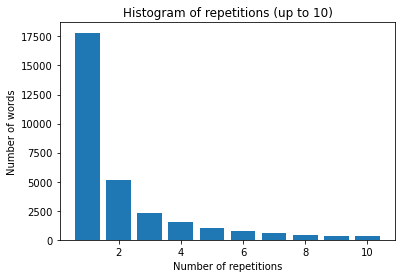

In [12]:
(x_values, y_values) = zip(*hist_quixote[:10])
plt.bar(x_values, y_values)
plt.title('Histogram of repetitions (up to 10)')
plt.xlabel('Number of repetitions')
plt.ylabel('Number of words')
plt.show()

## Exercise 2. Histogram of the length of the words

Provide a histogram of the length of the words. Word repetition is not a problem, so if you have the word 'bye' twice in your document, you would add 2 to the number of words of length 3.

* Length 1 - 100 times
* Length 2 - 300 times
* Length 3 - 400 times
...

You are asked to implement a `histogram_length(file_path)` function in Spark. All the processing must be done with RDDs, and there should be a single `collect()` at the end to return a list. The list must be ordered by the length of the words.

**Input**: The path to a text file

**Output**: (Length, number of words)

**Note: We are going to assume that the maximum word length is 16 characters, so anything above that shouldn't appear in the result.**

                                                                                                       [25 marks]

In [ ]:
def histogram_length(file_path):
    # <FILL-IN WITH YOUR CODE>

histogram_length("data/quixote.txt")

The program should pass the following test:

In [ ]:
length_quixote = histogram_length("data/quixote.txt")
print(length_quixote)
test(length_quixote, [(1, 12978), (2, 80003), (3, 98414), (4, 80717), (5, 45809), 
                                   (6, 33672), (7, 30995), (8, 19570), (9, 12350), (10, 7929),
                                   (11, 3849), (12, 2043), (13, 963), (14, 539), (15, 251), (16, 110)],"Try again!")

### Task: Draw the histogram

In [ ]:
# <FILL-IN WITH YOUR CODE>

## Exercise 3. Average length of the words in a document

You are now asked to implement an `average_length(file_path)` function in Spark that provides the average length of the words in a document or documents. All the processing must be done with RDDs, and the last instruction must be the only one returning a result to the driver. 

**Input**: The path to a text file

**Output**: Average length of the words

**Note: Again, we are going to assume that the maximum word length is 16 characters, so anything above that shouldn't be used to compute the average**

You can do it in two different ways (you can try both and check possible differences): 

- **Option 1**. As we have done in the previous lab: you will need to get the total length of the words in the text and the total number of words in just one MapReduce job. Then, you just need to make the division.


                                                                                                       [15 marks]

In [ ]:
def average_length(file_path):
    # <FILL-IN WITH YOUR CODE>
    
average_length("data/quixote.txt")

The program should pass the following test:

In [ ]:
avg = average_length("data/quixote.txt")
test(round(avg,5), 4.36684,'Try again!')

- **Option 2**. Using some built-in functions from Spark: you can think of a function available from Spark API that can simplify the implementation.

                                                                                                       [10 marks]

In [ ]:
def average_length(file_path):
    # <FILL-IN WITH YOUR CODE>
    
average_length("data/quixote.txt")

The program should pass the following test:

In [ ]:
avg = average_length("data/quixote.txt")
test(round(avg,5), 4.36684,'Try again!')

## Exercise 4. Find a list of common friends between pairs of friends

Obtain a list of common friends for each pair of friends. That is, for each two people that are friends (assuming friendship is bi-directional), you need to find the friends in common.

You are asked to implement a function `common_friends(file_path)` that reads a file that contains a list of friends for each person. The function should output for each pair of friends, the list of common friends.

**Input**: A file with the following format: Person -> List of friends. 

```
Isaac -> Mikel John Lucy
Mikel -> Isaac John Lucy Claudia
John -> Isaac Mikel Lucy Claudia
Lucy -> Isaac Mikel John Claudia
Claudia -> Mikel John Lucy
```

**Output**: (pair of friends, list of common friends)
```
(Isaac, Mikel)    -> [John, Lucy]
(Claudia, Mikel)  -> [John, Lucy]
(John, Lucy)      -> [Claudia, Isaac, Mikel]
(Isaac, John)     -> [Lucy, Mikel]
(Isaac, Lucy)     -> [John, Mikel]
(John, Mikel)     -> [Claudia, Isaac, Lucy]
(Lucy, Mikel)     -> [Claudia, Isaac, John]
(Claudia, John)   -> [Lucy, Mikel]
(Claudia, Lucy)   -> [John, Mikel]

```

You could follow similar steps to the ones in the previous exercise:

- Parse the input file to create an RDD of tuples like this: 

```
[
 ('Isaac', ['Mikel', 'John', 'Lucy']),
 ('Mikel', ['Isaac', 'John', 'Lucy', 'Claudia']),
 ('John', ['Isaac', 'Mikel', 'Lucy', 'Claudia']),
 ('Lucy', ['Isaac', 'Mikel', 'John', 'Claudia']),
 ('Claudia', ['Mikel', 'John', 'Lucy'])
]
```

- For each one of these, we would recommend a function to create a list of tuples that looks like this:

```
[
 (('Isaac', 'Mikel'), ['Mikel', 'John', 'Lucy']),
 (('Isaac', 'John'), ['Mikel', 'John', 'Lucy']),
 (('Isaac', 'Lucy'), ['Mikel', 'John', 'Lucy'])
]
```

**Note**:  Make sure you sort the tuples that will be acting as keys. Lists cannot be used as keys in Spark because they are mutable. When you sort a tuple with `sorted`, you will get a list, which must be converted back to a tuple.
 
- You will have to aggregate those results by key and perform the final intersection of list of friends.

                                                                                                       [25 marks]

In [90]:
def getPerson(string):
    return string[0:string.find('-') - 1]

def getFriends(string):
    friends = string[string.find('>') + 2::]
    friendsList = friends.split(' ')
    return friendsList

def splitFriendList(keyList, value):
    relationshipList = []
    
    for key in keyList:
        relationshipList.append(key + ", " + value)
        
    return relationshipList

def getRelationshipComb(key, valueList):
    relationshipCombList = []
    
    for i in range(len(valueList)):
        j = i + 1
        
        while j < len(valueList):
            relationshipCombList.append(valueList[i] + " " + valueList[j] + ", " + key)
            j += 1
    
    return relationshipCombList

def getRelationshipCombTuple(string):
    relationshipComb = string[0:string.find(',')]
    relationshipCombList = relationshipComb.split(' ')
    relationshipCombList.sort()
    return tuple(relationshipCombList)
    
def common_friends(file_path):
    # <FILL-IN WITH YOUR CODE>
    lines = sc.textFile(file_path, 10)
    mapFriendLists = lines.map(lambda line: (getFriends(line), getPerson(line)))
    mapRelationshipList = mapFriendLists.flatMap(lambda x: splitFriendList(x[0], x[1]))
    mapRelationships = mapRelationshipList.map(lambda relationship: (relationship[0:relationship.find(',')], 
                                                                    [relationship[relationship.find(' ') 
                                                                                 + 1::]]))
    mapPersonFriendList = mapRelationships.reduceByKey(lambda list1, list2: list1 + list2)
    mapRelationshipCombList = mapPersonFriendList.flatMap(lambda x: getRelationshipComb(x[0], x[1]))
    mapRelationshipComb = mapRelationshipCombList.map(lambda string: (getRelationshipCombTuple(string),
                                                                     [string[string.find(',') + 2::]]))
    output = mapRelationshipComb.reduceByKey(lambda list1, list2: list1 + list2)
    outputSortedValues = output.map(lambda x: (x[0], sorted(x[1])))
    return outputSortedValues.collect()

common_friends("data/friends.txt")

[(('Isaac', 'Mikel'), ['John', 'Lucy']),
 (('John', 'Lucy'), ['Claudia', 'Isaac', 'Mikel']),
 (('Claudia', 'Isaac'), ['John', 'Lucy', 'Mikel']),
 (('Claudia', 'Lucy'), ['John', 'Mikel']),
 (('John', 'Mikel'), ['Claudia', 'Isaac', 'Lucy']),
 (('Lucy', 'Mikel'), ['Claudia', 'Isaac', 'John']),
 (('Claudia', 'John'), ['Lucy', 'Mikel']),
 (('Isaac', 'Lucy'), ['John', 'Mikel']),
 (('Claudia', 'Mikel'), ['John', 'Lucy']),
 (('Isaac', 'John'), ['Lucy', 'Mikel'])]

The program should pass the following test.

In [91]:
test(sorted(map(lambda t: (t[0], sorted(t[1])), common_friends("data/friends.txt"))), 
                  sorted(map(lambda t: (t[0], sorted(t[1])), [(('Isaac', 'Mikel'), ['John', 'Lucy']),
                                                              (('Claudia', 'Mikel'), ['John', 'Lucy']),
                                                              (('John', 'Lucy'), ['Claudia', 'Isaac', 'Mikel']),
                                                              (('Isaac', 'John'), ['Lucy', 'Mikel']),
                                                              (('Isaac', 'Lucy'), ['John', 'Mikel']),
                                                              (('John', 'Mikel'), ['Claudia', 'Isaac', 'Lucy']),
                                                              (('Lucy', 'Mikel'), ['Claudia', 'Isaac', 'John']),
                                                              (('Claudia', 'John'), ['Lucy', 'Mikel']),
                                                              (('Claudia', 'Lucy'), ['John', 'Mikel'])])), 
                  'Try again!')

1 test failed. Try again!
